## 2차 발표 RS 우선 분석

### 데이터 로딩 및 전처리

In [53]:
import pandas as pd
import numpy as np

# 사용자 제공 파일 로딩
player_info = pd.read_csv("player_info_sample.csv")

# salary_next 쉼표 제거 → 숫자 변환
player_info["salary_next"] = (
    player_info["salary_next"].astype(str).str.replace(",", "").astype(float)
)

# 원화 변환 및 로그 변환
player_info["salary_next_won"] = player_info["salary_next"] * 10000
player_info["log_salary_next"] = np.log(player_info["salary_next_won"])

### 성적 데이터 수집 (kbodata 활용)

In [ ]:
import kbodata

chromedriver_path = "/Users/unusual/Downloads/chromedriver-mac-arm64/chromedriver"

# 예시: 2019~2023 연도별 경기 일정과 로그 수집
years = [2024]

all_pitchers = []
all_scoreboards = []

for year in years:
    try:
        sched = kbodata.get_yearly_schedule(year, chromedriver_path)
        game_data = kbodata.get_game_data(sched, chromedriver_path)

        pitcher_df = kbodata.pitcher_to_DataFrame(game_data)
        scoreboard_df = kbodata.scoreboard_to_DataFrame(game_data)

        # 연도 정보 붙이기
        pitcher_df["year"] = year
        scoreboard_df["year"] = year

        all_pitchers.append(pitcher_df)
        all_scoreboards.append(scoreboard_df)

    except Exception as e:
        print(f"[ERROR] {year}년 처리 실패: {e}")

in progress:   1%|▍                                                                               | 5/866 [00:06<17:43,  1.24s/it]

In [188]:
pitcher_df = pd.concat(all_pitchers, ignore_index=True)
scoreboard_df = pd.concat(all_scoreboards, ignore_index=True)

In [189]:
print("🎯 pitcher_df 타입:")
print(pitcher_df.dtypes)

print("\n🎯 scoreboard_df 타입:")
print(scoreboard_df.dtypes)

🎯 pitcher_df 타입:
idx           object
name          object
team          object
mound         object
inning        object
result        object
strikeout      int64
dead4ball      int64
losescore      int64
earnedrun      int64
pitchnum       int64
hitted         int64
homerun        int64
battednum      int64
batternum      int64
year           int64
IP           float64
WHIP         float64
dtype: object

🎯 scoreboard_df 타입:
idx          object
team         object
result        int64
i_1           int64
i_2           int64
i_3           int64
i_4           int64
i_5           int64
i_6          object
i_7          object
i_8          object
i_9          object
i_10         object
i_11         object
i_12         object
i_13         object
i_14         object
i_15         object
i_16         object
i_17         object
i_18         object
r             int64
h             int64
e             int64
b             int64
year          int64
month         int64
day           int64
week      

In [190]:
def convert_inning_str_to_float(s):
    try:
        s = str(s).zfill(2)
        full = int(s[:-1])
        partial = int(s[-1])
        return full + {0: 0.0, 1: 1/3, 2: 2/3}.get(partial, 0)
    except:
        return 0

pitcher_df["IP"] = pitcher_df["inning"].apply(convert_inning_str_to_float)

In [191]:
season_stats = pitcher_df.groupby(["name", "year"]).agg({
    "result": lambda x: (x == "W").sum(),   # 승수
    "IP": "sum",
    "strikeout": "sum",
    "dead4ball": "sum",
    "earnedrun": "sum"
}).reset_index()

# 변수명 정리
season_stats = season_stats.rename(columns={"result": "W"})

# 파생 변수 계산
season_stats["ERA"] = season_stats["earnedrun"] * 9 / season_stats["IP"]
season_stats["K9"] = season_stats["strikeout"] * 9 / season_stats["IP"]
season_stats["BB9"] = season_stats["dead4ball"] * 9 / season_stats["IP"]

In [192]:
def get_inning_range(ip_float):
    full = int(ip_float)
    partial = ip_float - full
    innings = list(range(1, full + 1))
    if partial >= 1/3:
        innings.append(full + 1)
    return innings

def calculate_rs(pitcher_df, scoreboard_df):
    rs_list = []

    for _, row in pitcher_df.iterrows():
        idx = row["idx"]
        team = row["team"]
        ip = row["IP"]

        innings = get_inning_range(ip)
        sb_row = scoreboard_df[scoreboard_df["idx"] == idx]
        if sb_row.empty:
            rs_list.append(None)
            continue

        sb = sb_row.iloc[0]
        team_name = team.strip()
        home = sb["home"].strip()
        away = sb["away"].strip()

        # 이 투수가 홈인지 원정인지 판단
        if team_name == home:
            score_prefix = "i_"
        elif team_name == away:
            score_prefix = "i_"
        else:
            rs_list.append(None)
            continue

        # 해당 팀의 이닝 점수 가져오기
        scores = []
        for i in innings:
            col = f"i_{i}"
            try:
                val = int(sb[col]) if sb[col] != "-" else 0
            except:
                val = 0
            scores.append(val)

        rs_list.append(sum(scores))

    pitcher_df["RS"] = rs_list
    return pitcher_df

In [193]:
pitcher_with_ip = pitcher_df[pitcher_df["IP"] > 0]  # 등판 기록 있는 투수만

pitcher_with_rs = calculate_rs(pitcher_with_ip, scoreboard_df)

# 시즌별 RS 총합 요약
rs_stats = pitcher_with_rs.groupby(["name", "year"]).agg({
    "RS": "sum"
}).reset_index()

/var/folders/48/s46fmd9166lflhx4v40_hps80000gn/T/ipykernel_67732/1824055328.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitcher_df["RS"] = rs_list


In [195]:
season_stats = pd.merge(season_stats, rs_stats, on=["name", "year"], how="left")

In [196]:
player_info = pd.read_csv("player_info_sample.csv")
player_info = player_info.dropna()

# 컬럼명 정리 (name, year 기준 통일)
player_info = player_info.rename(columns={
    "player_name": "name",
    "season": "year"
})

# 연도 타입 정리
player_info["year"] = player_info["year"].astype(int)

# 연봉 전처리
player_info["salary_next"] = (
    player_info["salary_next"].astype(str).str.replace(",", "").astype(float)
)
player_info["salary_next_won"] = player_info["salary_next"] * 10000
player_info["log_salary_next"] = np.log(player_info["salary_next_won"])

In [197]:
df = pd.merge(season_stats, player_info, on=["name", "year"], how="inner")

In [198]:
import statsmodels.api as sm

# 연도 더미 추가
df = pd.get_dummies(df, columns=["year"], prefix="year", drop_first=True)

# 회귀 변수 목록
features = ["RS", "IP", "K9", "BB9"] + [c for c in df.columns if c.startswith("year_")]
X = df[features]
X = sm.add_constant(X)
y = df["W"]

# 결측 제거
valid_idx = X.notnull().all(axis=1) & y.notnull()
X_valid = X[valid_idx].astype(float)
y_valid = y[valid_idx].astype(float)

# 회귀 실행
model = sm.OLS(y_valid, X_valid).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     21.21
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.74e-11
Time:                        02:03:44   Log-Likelihood:                -120.13
No. Observations:                  44   AIC:                             258.3
Df Residuals:                      35   BIC:                             274.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0298      4.128     -0.976      0.3

In [176]:
import statsmodels.api as sm

# 설명변수와 종속변수
X_rs = sm.add_constant(merged_df[["RS"]])  # 상수항 추가
y_salary = merged_df["log_salary_next"]

# 유효 데이터 필터링
valid_idx = X_rs.notnull().all(axis=1) & y_salary.notnull()
X_valid_rs = X_rs[valid_idx]
y_valid_salary = y_salary[valid_idx]

# 회귀 실행
model_rs = sm.OLS(y_valid_salary, X_valid_rs).fit()
print(model_rs.summary())

                            OLS Regression Results                            
Dep. Variable:        log_salary_next   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     32.61
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.04e-06
Time:                        01:15:59   Log-Likelihood:                -54.907
No. Observations:                  44   AIC:                             113.8
Df Residuals:                      42   BIC:                             117.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3000      0.308     26.909      0.0

# 여기까지 1차 회귀식 완료

In [167]:
# 'year' → 'season' 으로 컬럼명 변경
season_stats = season_stats.rename(columns={"year": "season"})

In [168]:
season_stats = season_stats.rename(columns={"name": "player_name"})

In [169]:
merged_df = pd.merge(season_stats, player_info, how="inner", on=["player_name", "season"])

KeyError: 'player_name'

In [170]:
# CSV 불러오기
player_info = pd.read_csv("player_info_sample.csv")

# 혹시 첫 행이 NaN이면 제거
player_info = player_info.dropna(subset=["player_name"])

# 컬럼명 통일 (병합을 위해)
player_info["season"] = player_info["season"].astype(int)
season_stats["season"] = season_stats["season"].astype(int)

# 병합
merged_df = pd.merge(season_stats, player_info, how="inner", on=["player_name", "season"])

# 연봉 문자열 -> 숫자
merged_df["salary_next_won"] = (
    merged_df["salary_next"].astype(str).str.replace(",", "").astype(float)
)

# 로그 연봉
merged_df["log_salary_next"] = np.log1p(merged_df["salary_next_won"])

In [171]:
print(player_info.columns)
print(season_stats.columns)

Index(['player_name', 'season', 'salary_next', 'fa', 'age'], dtype='object')
Index(['player_name', 'season', 'W', 'IP', 'strikeout', 'dead4ball',
       'earnedrun', 'ERA', 'K9', 'BB9', 'RS'],
      dtype='object')


In [177]:
# 연도 더미 변수 추가
df = pd.get_dummies(merged_df, columns=["season"], prefix="year", drop_first=True)

# 설명 변수 + 상수항
features = ["W", "IP", "K9", "BB9", "fa", "age"] + [c for c in df.columns if c.startswith("year_")]
X = sm.add_constant(df[features])
y = df["log_salary_next"]

# NaN 제거 (혹시 있을 경우)
valid_idx = X.notnull().all(axis=1) & y.notnull()
X_valid = X[valid_idx]
y_valid = y[valid_idx]

In [173]:
model = sm.OLS(y_valid, X_valid).fit()
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [178]:
print(X_valid.dtypes)
print(y_valid.dtypes)

const        float64
W              int64
IP           float64
K9           float64
BB9          float64
fa           float64
age          float64
year_2020       bool
year_2021       bool
year_2022       bool
year_2023       bool
dtype: object
float64


In [179]:
# year 더미 컬럼들을 int로 변환
X_valid.loc[:, ["year_2020", "year_2021", "year_2022", "year_2023"]] = \
    X_valid[["year_2020", "year_2021", "year_2022", "year_2023"]].astype(int)

# 회귀 실행
model = sm.OLS(y_valid, X_valid).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_salary_next   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     13.05
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           7.91e-09
Time:                        01:38:36   Log-Likelihood:                -32.340
No. Observations:                  44   AIC:                             86.68
Df Residuals:                      33   BIC:                             106.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4728      1.084      5.974      0.0

/var/folders/48/s46fmd9166lflhx4v40_hps80000gn/T/ipykernel_67732/850691817.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X_valid.loc[:, ["year_2020", "year_2021", "year_2022", "year_2023"]] = \
/var/folders/48/s46fmd9166lflhx4v40_hps80000gn/T/ipykernel_67732/850691817.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 0 1 0 0 1 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X_valid.loc[:, ["year_2020", "year_2021", "year_2022", "year_2023"]] = \
/var/folders/48/s46fmd9166lflhx4v40_hps80000gn/T/ipykernel_67732/850691817.py:2: FutureWarning: 

In [199]:
# ERA를 제외한 설명 변수 구성
features_reduced = ["W", "K9", "BB9", "fa", "age"] + [c for c in df.columns if c.startswith("year_")]

# 독립 변수 X와 종속 변수 y 정의
X = sm.add_constant(df[features_reduced])
y = df["log_salary_next"]

# NaN 제거 (혹시 있을 경우)
valid_idx = X.notnull().all(axis=1) & y.notnull()
X_valid = X[valid_idx]
y_valid = y[valid_idx]

# 연도 더미 변수들을 int로 변환 (있다면)
year_cols = [col for col in X_valid.columns if col.startswith("year_")]
X_valid[year_cols] = X_valid[year_cols].astype(int)

# 회귀 실행
model = sm.OLS(y_valid, X_valid).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_salary_next   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     12.31
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.25e-08
Time:                        02:05:00   Log-Likelihood:                -35.679
No. Observations:                  44   AIC:                             91.36
Df Residuals:                      34   BIC:                             109.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5672      1.078     15.364      0.0

In [77]:
import os

save_dir = "kbodata_output"
os.makedirs(save_dir, exist_ok=True)

for year in years:
    try:
        sched = kbodata.get_yearly_schedule(year, chromedriver_path)
        game_data = kbodata.get_game_data(sched, chromedriver_path)

        pitcher_df = kbodata.pitcher_to_DataFrame(game_data)
        scoreboard_df = kbodata.scoreboard_to_DataFrame(game_data)

        pitcher_df["year"] = year
        scoreboard_df["year"] = year

        # 저장
        pitcher_df.to_csv(f"{save_dir}/pitchers_{year}.csv", index=False)
        scoreboard_df.to_csv(f"{save_dir}/scoreboards_{year}.csv", index=False)

        all_pitchers.append(pitcher_df)
        all_scoreboards.append(scoreboard_df)

    except Exception as e:
        print(f"[ERROR] {year}년 처리 실패: {e}")

in progress: 100%|██████████████████████████████████████████████████████████████████████████████| 897/897 [16:46<00:00,  1.12s/it]


In [78]:
# 처리 후 맨 아래에 추가
import pandas as pd

if all_pitchers:
    total_pitchers = pd.concat(all_pitchers, ignore_index=True)
    total_pitchers.to_csv(f"{save_dir}/all_pitchers_2019_2023.csv", index=False)

if all_scoreboards:
    total_scoreboards = pd.concat(all_scoreboards, ignore_index=True)
    total_scoreboards.to_csv(f"{save_dir}/all_scoreboards_2019_2023.csv", index=False)

In [79]:
X_valid.columns

Index(['const', 'W', 'ERA', 'IP', 'K9', 'BB9', 'fa', 'age', 'year_2020',
       'year_2021', 'year_2022', 'year_2023'],
      dtype='object')

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# const 제외
X_no_const = X_valid.drop(columns=['const'])

# VIF 계산
vif_df = pd.DataFrame()
vif_df["feature"] = X_no_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])]

print(vif_df)

     feature        VIF
0          W   7.838416
1         K9  20.078852
2        BB9  10.913063
3         fa   1.195761
4        age  14.262228
5  year_2020   2.269453
6  year_2021   2.723905
7  year_2022   2.647331
8  year_2023   2.406927


In [81]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# Lasso는 표준화가 꼭 필요해
lasso_pipeline = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, random_state=0)
)

# 학습
lasso_pipeline.fit(X_valid, y_valid)

# 계수 확인
lasso = lasso_pipeline.named_steps['lassocv']
coefficients = pd.Series(lasso.coef_, index=X_valid.columns)

print("💡 Lasso 회귀 계수:")
print(coefficients)

# 어떤 변수가 얼마나 줄었는지 보기 좋게 정렬해서 출력
print("\n🔍 중요한 변수 순위:")
print(coefficients[coefficients != 0].sort_values(key=abs, ascending=False))

💡 Lasso 회귀 계수:
const        0.000000
W            0.000000
ERA         -0.071688
IP           0.487537
K9           0.001598
BB9         -0.174095
fa          -0.004630
age          0.395725
year_2020    0.000000
year_2021   -0.000000
year_2022   -0.000000
year_2023    0.044887
dtype: float64

🔍 중요한 변수 순위:
IP           0.487537
age          0.395725
BB9         -0.174095
ERA         -0.071688
year_2023    0.044887
fa          -0.004630
K9           0.001598
dtype: float64


In [180]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

years = sorted(df["season"].unique())
w_coefs = []

for year in years:
    df_year = df[df["season"] == year]

    X = sm.add_constant(df_year[["W"]])
    y = df_year["log_salary_next"]

    if len(df_year) >= 5:  # 최소 관측치 보장
        model = sm.OLS(y, X).fit()
        w_coefs.append(model.params["W"])
    else:
        w_coefs.append(None)  # 부족한 경우 제외

# 시각화
plt.plot(years, w_coefs, marker="o")
plt.title("연도별 W의 회귀계수 추이")
plt.xlabel("Season")
plt.ylabel("Coefficient of W")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

KeyError: 'season'

In [181]:
print(merged_df.columns)

Index(['player_name', 'season', 'W', 'IP', 'strikeout', 'dead4ball',
       'earnedrun', 'ERA', 'K9', 'BB9', 'RS', 'salary_next', 'fa', 'age',
       'salary_next_won', 'log_salary_next'],
      dtype='object')


In [182]:
merged_df = merged_df.rename(columns={"year": "season"})

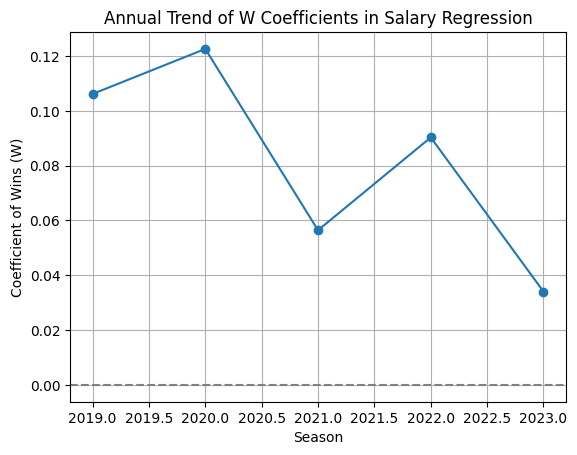

In [184]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# season 컬럼 보장
if "season" not in merged_df.columns and "year" in merged_df.columns:
    merged_df = merged_df.rename(columns={"year": "season"})

years = sorted(merged_df["season"].dropna().unique())
w_coefs = []

for year in years:
    df_year = merged_df[merged_df["season"] == year]

    if len(df_year) >= 5:
        X = sm.add_constant(df_year[["W"]])
        y = df_year["log_salary_next"]
        model = sm.OLS(y, X).fit()
        w_coefs.append(model.params["W"])
    else:
        w_coefs.append(None)  # 관측치 부족 시 제외

# 그래프
plt.plot(years, w_coefs, marker="o")
plt.title("Annual Trend of W Coefficients in Salary Regression")
plt.xlabel("Season")
plt.ylabel("Coefficient of Wins (W)")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

In [185]:
import statsmodels.api as sm

# 설명 변수: RS만 사용
X = sm.add_constant(df[["RS"]])  # 상수항 추가
y = df["W"]

# 결측값 제거 및 타입 통일
valid_idx = X.notnull().all(axis=1) & y.notnull()
X_valid = X[valid_idx].astype(float)
y_valid = y[valid_idx].astype(float)

# 회귀 실행
model = sm.OLS(y_valid, X_valid).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     116.0
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.18e-13
Time:                        01:49:24   Log-Likelihood:                -129.84
No. Observations:                  44   AIC:                             263.7
Df Residuals:                      42   BIC:                             267.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6282      1.694     -0.371      0.7

In [202]:
season_stats = pitcher_df.groupby(["name", "year"]).agg({
    "result": lambda x: (x == "W").sum(),   # 승수
    "IP": "sum",
    "strikeout": "sum",
    "dead4ball": "sum",
    "earnedrun": "sum",
    "hitted": "sum",         # ✅ 추가
    "homerun": "sum"         # ✅ FIP 계산용 추가
}).reset_index()

# 변수명 정리
season_stats = season_stats.rename(columns={"result": "W"})

# 파생 변수
season_stats["ERA"] = season_stats["earnedrun"] * 9 / season_stats["IP"]
season_stats["K9"] = season_stats["strikeout"] * 9 / season_stats["IP"]
season_stats["BB9"] = season_stats["dead4ball"] * 9 / season_stats["IP"]

# ✅ 여기서 WHIP, FIP도 같이 만들자
season_stats["WHIP"] = (season_stats["hitted"] + season_stats["dead4ball"]) / season_stats["IP"]
FIP_constant = 3.2
season_stats["FIP"] = (
    (13 * season_stats["homerun"] + 3 * season_stats["dead4ball"] - 2 * season_stats["strikeout"]) 
    / season_stats["IP"] + FIP_constant
)

In [203]:
df = pd.merge(season_stats, player_info, on=["name", "year"], how="inner")

In [205]:
# 컬럼명 확인
print(player_info.columns)

# 만약 'season' 대신 'year'만 있다면, 이 라인은 생략하거나 아래처럼 처리
if "season" in player_info.columns:
    player_info["year"] = player_info["season"].astype(int)

# 이어서 계속 진행
season_stats["year"] = season_stats["year"].astype(int)
season_stats = season_stats.rename(columns={"name": "player_name"})

# 병합
merged_df = pd.merge(season_stats, player_info, how="inner", on=["player_name", "year"])

Index(['name', 'year', 'salary_next', 'fa', 'age', 'salary_next_won',
       'log_salary_next'],
      dtype='object')


KeyError: 'player_name'

In [206]:
print(player_info.columns)
print(season_stats.columns)

Index(['name', 'year', 'salary_next', 'fa', 'age', 'salary_next_won',
       'log_salary_next'],
      dtype='object')
Index(['player_name', 'year', 'W', 'IP', 'strikeout', 'dead4ball', 'earnedrun',
       'hitted', 'homerun', 'ERA', 'K9', 'BB9', 'WHIP', 'FIP'],
      dtype='object')


In [207]:
season_stats = season_stats.rename(columns={"player_name": "name"})

In [208]:
merged_df = pd.merge(season_stats, player_info, how="inner", on=["name", "year"])

In [227]:
# 연도 더미 처리
df = pd.get_dummies(merged_df, columns=["year"], prefix="year", drop_first=True)

# 변수 선택
features = ["W", "WHIP", "FIP", "IP", "K9", "BB9", "fa", "age"] + \
           [col for col in df.columns if col.startswith("year_")]

# X, y 구성
X = sm.add_constant(df[features])
y = df["log_salary_next"]

# 결측 제거
valid_idx = X.notnull().all(axis=1) & y.notnull()
X_valid = X[valid_idx].astype(float)
y_valid = y[valid_idx].astype(float)

In [228]:
import statsmodels.api as sm

# OLS 회귀 실행
model = sm.OLS(y_valid, X_valid).fit()

# 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_salary_next   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     13.46
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           3.99e-09
Time:                        02:54:17   Log-Likelihood:                -27.373
No. Observations:                  44   AIC:                             80.75
Df Residuals:                      31   BIC:                             103.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.8950      1.870      9.567      0.0

In [229]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# const(상수항) 제외하고 VIF 계산
X_vif = X_valid.drop(columns=["const"])

vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# VIF 값 큰 순으로 출력
print(vif_df.sort_values(by="VIF", ascending=False))

      feature         VIF
1        WHIP  148.729248
2         FIP   98.120019
7         age   46.076461
5         BB9   38.603404
3          IP   36.611050
4          K9   24.828857
0           W   22.011925
10  year_2022    3.180211
9   year_2021    2.891235
11  year_2023    2.614377
8   year_2020    2.379302
6          fa    1.206721


# PCA

In [240]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 1. 설명변수 추출
features = ["W", "ERA", "IP", "K9", "BB9", "WHIP", "FIP", "age", "fa"]
X = df[features].dropna()
y = df.loc[X.index, "log_salary_next"]

# 2. PCA + 회귀
model = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
model.fit(X, y)
print("R² score:", model.score(X, y))

R² score: 0.7821724150256271


In [242]:
make_pipeline(
    StandardScaler(),      # 모든 변수 표준화
    PCA(n_components=5),   # 상위 5개의 주성분으로 축소
    LinearRegression()     # OLS 회귀
)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('linearregression', LinearRegression())])

In [243]:
for n in range(2, 10):
    ...
    PCA(n_components=n)

In [244]:
model.named_steps["linearregression"].coef_

array([-0.39200004, -0.35309795, -0.12541646,  0.03424821,  0.2546234 ])

In [246]:
features = ["W", "ERA", "IP", "K9", "BB9", "WHIP", "FIP", "age", "fa"]  # 총 9개여야 함
X = df[features].dropna()
y = df.loc[X.index, "log_salary_next"]

# PCA 로딩값
pca = model.named_steps["pca"]
loadings = pd.DataFrame(pca.components_.T,
                        index=features,
                        columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print(loadings)

           PC1       PC2       PC3       PC4       PC5
W    -0.382193 -0.089841 -0.251968  0.556144  0.050252
ERA   0.413775 -0.193138 -0.031337  0.230400  0.096226
IP   -0.387562 -0.151592 -0.209278  0.469642 -0.164497
K9   -0.189344  0.636136 -0.035316  0.017048  0.463725
BB9   0.343645  0.368726 -0.096368  0.285176  0.383115
WHIP  0.404693 -0.171017 -0.163784  0.373732  0.191565
FIP   0.423161 -0.136978 -0.047521  0.073235 -0.167023
age  -0.181635 -0.584980  0.018339 -0.229321  0.729664
fa   -0.052324 -0.028395  0.922919  0.371232  0.048330


In [247]:
loadings = pd.DataFrame(pca.components_.T,
                        index=features,
                        columns=[f"PC{i+1}" for i in range(pca.n_components_)])

In [248]:
# 선택된 변수 기반 다중회귀
features = ["W", "IP", "BB9", "age", "fa"]  # 예시: 중복되는 FIP/ERA 제거 등
X_sel = sm.add_constant(df[features].dropna())
y_sel = df.loc[X_sel.index, "log_salary_next"]

model = sm.OLS(y_sel, X_sel).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_salary_next   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     26.12
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.42e-11
Time:                        03:21:33   Log-Likelihood:                -34.769
No. Observations:                  44   AIC:                             81.54
Df Residuals:                      38   BIC:                             92.24
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9662      0.920     17.349      0.0

In [249]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 설명변수와 타깃
features = ["W", "ERA", "IP", "K9", "BB9", "WHIP", "FIP", "age", "fa"]
X = df[features].dropna()
y = df.loc[X.index, "log_salary_next"]

# PCA 기반 회귀 모델
model = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
model.fit(X, y)

# 평가
r2 = model.score(X, y)
print("R² (with PCA):", r2)

R² (with PCA): 0.7821724150256271


In [234]:
import statsmodels.api as sm

# 설명 변수 설정 (원하는 회귀식 구성)
features = ["W", "K9", "fa", "age", "year_2020", "year_2021", "year_2022", "year_2023"]

# 회귀용 데이터 구성
X = sm.add_constant(df[features])
y = df["log_salary_next"]

# 결측값 제거
valid_idx = X.notnull().all(axis=1) & y.notnull()
X_valid = X[valid_idx].astype(float)
y_valid = y[valid_idx].astype(float)

# 회귀 실행
model = sm.OLS(y_valid, X_valid).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_salary_next   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     10.40
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.60e-07
Time:                        02:56:23   Log-Likelihood:                -40.779
No. Observations:                  44   AIC:                             99.56
Df Residuals:                      35   BIC:                             115.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.5457      0.927     15.686      0.0

In [235]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
vif_df["feature"] = X_valid.drop(columns=["const"]).columns
vif_df["VIF"] = [variance_inflation_factor(X_valid.drop(columns=["const"]).values, i)
                 for i in range(X_valid.shape[1] - 1)]

print(vif_df.sort_values(by="VIF", ascending=False))

     feature        VIF
3        age  12.532777
1         K9  11.545449
0          W   5.585406
5  year_2021   2.622817
6  year_2022   2.617467
7  year_2023   2.381023
4  year_2020   2.233753
2         fa   1.155084


In [238]:
# age 제외한 변수 목록
features_reduced = ["W", "K9", "fa", "year_2020", "year_2021", "year_2022", "year_2023"]

X_r = sm.add_constant(df[features_reduced])
y_r = df["log_salary_next"]

valid_idx_r = X_r.notnull().all(axis=1) & y_r.notnull()
X_valid_r = X_r[valid_idx_r].astype(float)
y_valid_r = y_r[valid_idx_r].astype(float)

model_reduced = sm.OLS(y_valid_r, X_valid_r).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:        log_salary_next   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     5.740
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           0.000164
Time:                        02:56:41   Log-Likelihood:                -51.059
No. Observations:                  44   AIC:                             118.1
Df Residuals:                      36   BIC:                             132.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1951      0.586     31.066      0.0

In [239]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
vif_df["feature"] = X_valid.drop(columns=["const"]).columns
vif_df["VIF"] = [variance_inflation_factor(X_valid.drop(columns=["const"]).values, i)
                 for i in range(X_valid.shape[1] - 1)]

print(vif_df.sort_values(by="VIF", ascending=False))

     feature        VIF
3        age  12.532777
1         K9  11.545449
0          W   5.585406
5  year_2021   2.622817
6  year_2022   2.617467
7  year_2023   2.381023
4  year_2020   2.233753
2         fa   1.155084


In [ ]:
import kbodata
import os

chromedriver_path = "/Users/unusual/Downloads/chromedriver-mac-arm64/chromedriver"
save_dir = "kbodata_output"
os.makedirs(save_dir, exist_ok=True)

# 2004~2018, 2024년 포함
retry_years = [2011, 2024]

for year in retry_years:
    try:
        print(f"[재시도] 처리 중: {year}년...")
        sched = kbodata.get_yearly_schedule(year, chromedriver_path)
        game_data = kbodata.get_game_data(sched, chromedriver_path)

        pitcher_df = kbodata.pitcher_to_DataFrame(game_data)
        scoreboard_df = kbodata.scoreboard_to_DataFrame(game_data)

        pitcher_df["year"] = year
        scoreboard_df["year"] = year

        # CSV 저장
        pitcher_df.to_csv(f"{save_dir}/pitchers_{year}.csv", index=False)
        scoreboard_df.to_csv(f"{save_dir}/scoreboards_{year}.csv", index=False)

        all_pitchers.append(pitcher_df)
        all_scoreboards.append(scoreboard_df)

        print(f"[성공] {year}년 저장 완료")

    except Exception as e:
        print(f"[ERROR] {year}년 재시도 실패: {e}")

[재시도] 처리 중: 2011년...


in progress:  10%|███████▉                                                                       | 68/680 [01:11<11:50,  1.16s/it]